## TimeSHAP

Used on Aachen dataset

In [1]:
import timeshap

# Import necessary functions and modules from the script
from LSTM_Model_Training import (
    get_config,
    preprocess_aachen_dataset,
    build_model,
    plot_training_history,
    plot_predictions_vs_actual,
    plot_residuals,
    explain_with_shap,
    save_model_structure_and_weights,
    load_model_structure_and_weights,
    get_unique_model_name
)

import pandas as pd
import tensorflow as tf

/opt/miniconda3/envs/timeshap_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import tensorflow as tf
print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)

NumPy: 1.23.5
TensorFlow: 2.18.0


<class 'numpy.ndarray'>
float32
(7190, 272, 1)
Attempting to load pre-trained model...
Checking for model files in the following paths:
Structure file: Aachen/Models/model_20250204_104213.structure.json
Weights file: Aachen/Models/model_20250204_104213.weights.h5
Contents of directory 'Aachen/Models':
['model_20250127_135003.structure.json', 'model_20250131_124416.weights.h5', 'model_20250127_135003.weights.h5', 'model_20250128_130021.structure.json', 'model_20250128_130021.weights.h5', 'model_20250131_123220.structure.json', 'model_20250131_124416.structure.json', 'model_20250131_123220.weights.h5']
No pre-trained model found. Training a new model...
Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0278 - mae: 0.1152 - val_loss: 0.0041 - val_mae: 0.0498
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0060 - mae: 0.0588 - val_loss: 0.0047 - val_mae: 0.0544
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0061 - mae: 0.0581 - val_loss: 0.0041 -

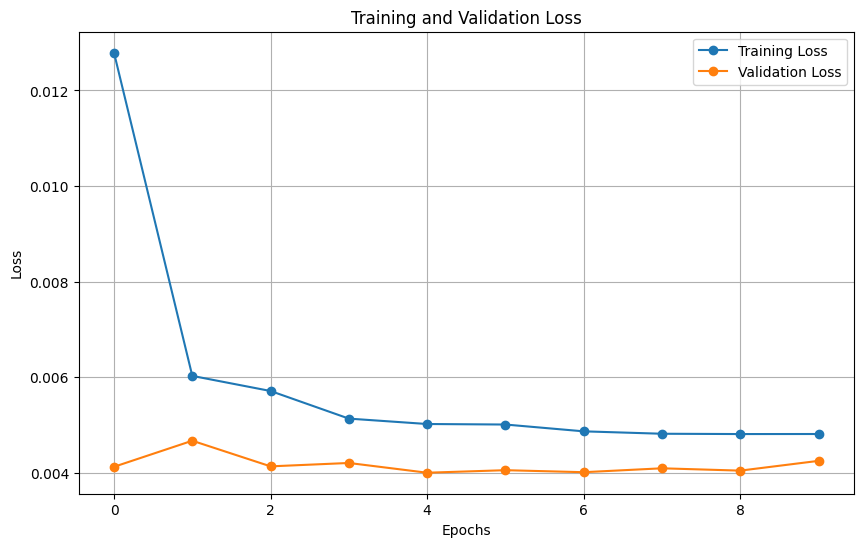

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.0200e-04 - mae: 0.0217

Test Loss: 0.0010560883674770594
Test MAE: 0.027660546824336052
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
   Actual RUL80  Predicted RUL80
0        1060.0      1030.426758
1        1055.0      1024.305786
2        1050.0      1018.156921
3        1045.0      1012.110291
4        1040.0      1006.247375


In [3]:
# Step 1: Load configuration
config = get_config()

# Step 2: Preprocess the Aachen dataset
data_path = "/Users/sigurdgjerdingen/Student/Master kode/Master_Herstad-Gjerdingen/Aachen/Degradation_Prediction_Dataset_ISEA.mat"
aachen_data = preprocess_aachen_dataset(
    data_path,
    test_cell_count=3,
    random_state=42,
    phase=None,
    log_transform=False,
)

# Extract the preprocessed data
X_train_lstm = aachen_data["X_train"]
X_val_lstm = aachen_data["X_val"]
X_test_lstm = aachen_data["X_test"]
y_train = aachen_data["y_train"]
y_val = aachen_data["y_val"]
y_test = aachen_data["y_test"]
y_max = aachen_data["y_max"]

print(type(X_train_lstm))               # Should be <class 'numpy.ndarray'>
print(X_train_lstm.dtype)               # Should be float32, float64, etc.
print(X_train_lstm.shape)  

# Step 3: Define model name for loading or saving
model_name = None
# model_name = "Aachen/Models/model_20250131_124416"
#model_name = "Aachen/Models/model_20250127_135003"  # Update as needed

if model_name is None:
    model_name = get_unique_model_name()

# Step 4: Load or train the model
try:
    print("Attempting to load pre-trained model...")
    model = load_model_structure_and_weights(model_name)
    print("Pre-trained model loaded successfully.")
except FileNotFoundError:
    print("No pre-trained model found. Training a new model...")

    # Build the model
    model = build_model(X_train_lstm.shape[1:], config)

    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', patience=config["patience"], restore_best_weights=True
        )
    ]

    # Train the model
    history = model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=config["epochs"],
        batch_size=config["batch_size"],
        verbose=1,
        callbacks=callbacks
    )

    # Save the best model after training
    save_model_structure_and_weights(model, model_name)
    print(f"New model saved as {model_name}")

    # Plot training history
    plot_training_history(history)

    # Step 5: Evaluate the model on the test set
test_loss, test_mae = model.evaluate(X_test_lstm, y_test, verbose=1)
print(f"\nTest Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test_lstm)

# Rescale predictions and test data back to the original range
y_pred_rescaled = y_pred.flatten() * y_max
y_test_rescaled = y_test * y_max

# Compare actual and predicted values
results = pd.DataFrame({
    "Actual RUL80": y_test_rescaled,
    "Predicted RUL80": y_pred_rescaled
})
print(results.head())

In [44]:
X_train_lstm.shape

# Type of data of each sample in the X_train_lstm
print(X_train_lstm.dtype)

float32


In [128]:
import numpy as np

X = X_train_lstm  # shape (7190, 272, 1), your dataset
X_flat = X.reshape(-1)  # flatten to 1D
valid_values = X_flat[X_flat != 0]  # remove zeros
# calculate the mean
X_train_baseline = valid_values.mean()
X_train_baseline = np.array([[X_train_baseline]])
X_train_baseline.shape

(1, 1)

In [116]:
# Expand the dimensions of the baseline prediction
X_train_baseline = np.expand_dims(X_train_baseline, axis=0)
X_train_baseline.shape

(1, 1, 1)

In [34]:
f = lambda x: model.predict(x)

In [107]:
# first column of X_train_lstm
X_train_first_step = X_train_lstm[:, 0:1, :]
X_train_first_step

(7190, 1, 1)

In [117]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(X_train_first_step, numerical_feats=[0], categorical_feats=[])

In [114]:
average_event

,0
0,0.970331


In [118]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(X_train_lstm, numerical_feats=[0], categorical_feats=[])

In [18]:
average_sequence

array([[0.97033083],
       [0.96485597],
       [0.95962405],
       [0.95496505],
       [0.94986749],
       [0.94406736],
       [0.93847591],
       [0.93283242],
       [0.92683303],
       [0.92197418],
       [0.91656721],
       [0.9119103 ],
       [0.9079718 ],
       [0.90332258],
       [0.89869916],
       [0.89460582],
       [0.88969505],
       [0.88499367],
       [0.88048345],
       [0.87600404],
       [0.87090576],
       [0.86547822],
       [0.86012429],
       [0.85537589],
       [0.85046899],
       [0.84591961],
       [0.84145355],
       [0.83707231],
       [0.83277726],
       [0.82856983],
       [0.82445151],
       [0.8204236 ],
       [0.8161521 ],
       [0.81243956],
       [0.80836076],
       [0.80389726],
       [0.79943138],
       [0.79496652],
       [0.79050601],
       [0.7870785 ],
       [0.78259325],
       [0.77868813],
       [0.77367008],
       [0.76947379],
       [0.76612657],
       [0.76281929],
       [0.75954413],
       [0.756

In [126]:
# Select a random row from LSTM training data with shape (7190, 272, 1) to be (1, 272, 1) while printing the selected row
selected_index = np.random.randint(X_train_lstm.shape[0])
random_row = X_train_lstm[selected_index][np.newaxis, :, :]
# remove the 0 values but keep the dimenteions  (1, x, 1)
random_row = random_row[random_row != 0].reshape(1, -1, 1)
random_row


(1, 199, 1)

In [120]:
from timeshap.explainer import local_report
# 1) Define pruning settings (optional)
pruning_dict = {
    'tol': 0.025
}

# 2) Define settings for event-level explanations
event_dict = {
    'rs': 42,            # random seed
    'nsamples': 32000    # number of coalitions to sample
}

# 3) Define settings for feature-level explanations
feature_dict = {
    'rs': 42,
    'nsamples': 32000,
    'feature_names': [0],          # The single feature is index 0
    'plot_features': {0: 'RUL'}    # A label to display in plots (renames feature 0 -> "RUL")
}

## 4) Define settings for cell-level explanations
#cell_dict = {
#    'rs': 42,
#    'nsamples': 32000,
#    'top_x_feats': 1,    # Only 1 feature total
#    'top_x_events': 1    # For example, show top 1 event
#}

# 5) Call local_report
plot = local_report(
    f=f,                      # Your model inference function, shape (n, seq_len, n_features) -> (n, 1)
    data=random_row,          # A single 3D array, shape = (1, seq_len, 1) or a DataFrame with one row
    pruning_dict=pruning_dict,
    event_dict=event_dict,
    feature_dict=feature_dict,   
    entity_uuid=[0],          # If you need an identifier; otherwise can be None
    entity_col=0,             # Or None if you're passing a plain np.array with no entity column
    baseline=X_train_baseline # A 2D array (seq_len, num_features) or your chosen baseline
)

Assuming all features are model features
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━

In [121]:
plot

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.HConcatChart(...)

In [53]:
from timeshap.plot import plot_temp_coalition_pruning, plot_event_heatmap, plot_feat_barplot, plot_cell_level
from timeshap.explainer import local_pruning, local_event, local_feat, local_cell_level

In [122]:
# Select first row of the LSTM training data
selected_row = X_train_lstm[0][np.newaxis, :, :]

selected_row.shape

(1, 272, 1)

In [132]:
pruning_dict = {'tol': 0.01,}
coal_plot_data, coal_prun_idx = local_pruning(f, random_row, pruning_dict, X_train_baseline, False)
# coal_prun_idx is in negative terms
pruning_idx = X_train_lstm.shape[1] + coal_prun_idx
pruning_plot = plot_temp_coalition_pruning(coal_plot_data, coal_prun_idx, plot_limit=200)
pruning_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)

In [80]:
event_dict = {'rs': 4, 'nsamples': 1000}
event_data = local_event(f, random_row, event_dict, entity_uuid=0, entity_col=0, baseline=X_train_baseline, pruned_idx=pruning_idx)
event_plot = plot_event_heatmap(event_data)
event_plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.


alt.LayerChart(...)